# Homework<br/>
### Complete task:
1) Find texts about cats, add 100+ random entries with text about cats and change its label to "Cat".You can add 'cats texts' to already used dataset in the notebook example 
2) Train the model to classify and catch texts about cats <br/>
### Simplified task: 
1) Find and use any model for sentimental text classification (with labels Positive, Negative, Neutral) on the already used dataset in notebook example
2) Compare metrics for your model and the bert fine-tuned model (accuracy and f1-score)


# Solutions
<hr/>

## 1. Complete task:

### Prepare data

#### Download Dataset


In [1]:
# !wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

#### Import libraries

In [2]:
import pandas as pd
import numpy as np

#### Load dataset and check how data looks like

In [3]:
df = pd.read_csv('AirlineTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

#### Taking only required columns

In [5]:
df = df[['airline_sentiment','text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

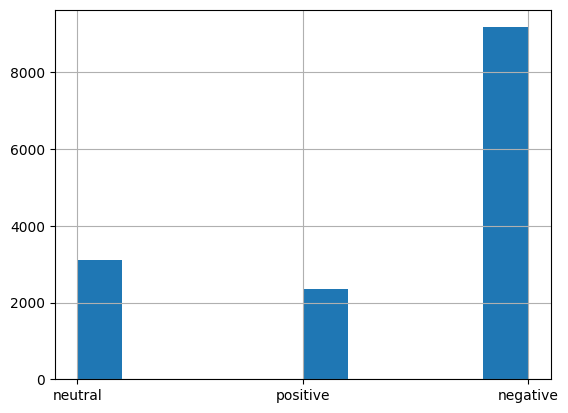

In [6]:
df['airline_sentiment'].hist()

Prepare text about cats

In [7]:
cat_df = pd.read_csv('cat_texts.csv')
cat_df.head()

,text,label
0,I love cuddling with my fluffy cat!,Cat
1,My cat enjoys playing with yarn balls.,Cat
2,The purring of my cat is so soothing.,Cat
3,Watching funny cat videos always cheers me up.,Cat
4,My cat likes to nap in the sunniest spots.,Cat


In [8]:
cat_df['label'] = 'Cat'
cat_df

,text,label
0,I love cuddling with my fluffy cat!,Cat
1,My cat enjoys playing with yarn balls.,Cat
2,The purring of my cat is so soothing.,Cat
3,Watching funny cat videos always cheers me up.,Cat
4,My cat likes to nap in the sunniest spots.,Cat
...,...,...
99,I'm endlessly grateful for the companionship o...,Cat
100,Life with a cat is a daily adventure filled wi...,Cat
101,"Even on the chilliest days, my cat's warmth br...",Cat
102,I love how my cat always greets me with a gent...,Cat


Mapping data to target_map and save as "data.csv"

In [9]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)
df1 = df[['text','target']]
df1.columns = ['sentence','label']
cat_df['label'] = 3 # target "cat"
cat_df.columns = ['sentence','label']
df1 = pd.concat([df1, cat_df], ignore_index=True)
df1.to_csv('data.csv', index = False)

#### Load data.csv and check how loaded dataset looks like

In [53]:
from datasets import load_dataset

raw_dataset = load_dataset('csv', data_files = 'data.csv')

raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14744
    })
})

### Creating model and training process

Split to train and test

In [11]:
split = raw_dataset['train'].train_test_split(test_size=0.25, seed=24)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11058
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3686
    })
})

#### Tokenize the data

In [12]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased' #choose the model
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

# Define tokenizer function
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

tokenized_dataset = split.map(tokenize_fn, batched = True)

Map: 100%|██████████| 3686/3686 [00:00<00:00, 9290.70 examples/s]


In [13]:
# Import classification model
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model has more than 108 M parameters and all they are trainable.

In [14]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           3,076
Total params: 10

In [15]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [16]:
from sklearn.metrics import f1_score

#Define evaluation metrics, which we will pass during training
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [17]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

c:\Users\Smeek\miniconda3\envs\Python_3_9\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [18]:
trainer.train()

  0%|          | 0/2076 [00:00<?, ?it/s]

 24%|██▍       | 500/2076 [38:35<2:01:01,  4.61s/it]

{'loss': 0.5507, 'grad_norm': 4.883872032165527, 'learning_rate': 3.7957610789980736e-05, 'epoch': 0.72}


                                                    
 33%|███▎      | 692/2076 [59:03<1:21:52,  3.55s/it]

{'eval_loss': 0.4053160548210144, 'eval_accuracy': 0.845360824742268, 'eval_f1_score': 0.845360824742268, 'eval_runtime': 345.5108, 'eval_samples_per_second': 10.668, 'eval_steps_per_second': 0.168, 'epoch': 1.0}


 48%|████▊     | 1000/2076 [1:22:55<1:24:03,  4.69s/it]

{'loss': 0.3504, 'grad_norm': 16.118602752685547, 'learning_rate': 2.5915221579961463e-05, 'epoch': 1.45}


                                                       
 67%|██████▋   | 1384/2076 [1:58:14<39:58,  3.47s/it]

{'eval_loss': 0.4759090840816498, 'eval_accuracy': 0.8431904503526858, 'eval_f1_score': 0.8431904503526858, 'eval_runtime': 347.8685, 'eval_samples_per_second': 10.596, 'eval_steps_per_second': 0.167, 'epoch': 2.0}


 72%|███████▏  | 1500/2076 [2:07:26<44:47,  4.67s/it]    

{'loss': 0.2569, 'grad_norm': 0.16725315153598785, 'learning_rate': 1.3872832369942197e-05, 'epoch': 2.17}


 96%|█████████▋| 2000/2076 [2:46:14<05:52,  4.64s/it]

{'loss': 0.1433, 'grad_norm': 13.009934425354004, 'learning_rate': 1.8304431599229288e-06, 'epoch': 2.89}


                                                     
100%|██████████| 2076/2076 [2:58:20<00:00,  5.96s/it]

{'eval_loss': 0.6122272610664368, 'eval_accuracy': 0.8545849158979925, 'eval_f1_score': 0.8545849158979925, 'eval_runtime': 364.4692, 'eval_samples_per_second': 10.113, 'eval_steps_per_second': 0.159, 'epoch': 3.0}


100%|██████████| 2076/2076 [2:58:22<00:00,  5.16s/it]

{'train_runtime': 10702.1029, 'train_samples_per_second': 3.1, 'train_steps_per_second': 0.194, 'train_loss': 0.3201612277756766, 'epoch': 3.0}


TrainOutput(global_step=2076, training_loss=0.3201612277756766, metrics={'train_runtime': 10702.1029, 'train_samples_per_second': 3.1, 'train_steps_per_second': 0.194, 'train_loss': 0.3201612277756766, 'epoch': 3.0})

### Predict

In [ ]:
!dir training_dir

In [21]:
from transformers import pipeline

In [43]:
saved_model = pipeline('text-classification',
                       model='training_dir/checkpoint-2076')


#### Adding some cats to test set

Because there are only few after splitting

In [115]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 3686
})

In [147]:
from datasets import Dataset

cats_dataset = load_dataset('csv', data_files="cat_texts.csv")
test_data_1 = cats_dataset['train'].train_test_split(test_size=0.7, seed=47)['train']
test_data_2 = split['test']
df_test_data_1 = test_data_1.to_pandas()
df_test_data_1['label'] = 3
df_test_data_2 = test_data_2.to_pandas()
df_test_data_1 = df_test_data_1.rename(columns={'text': 'sentence'})
merged_df = pd.concat([df_test_data_1, df_test_data_2], ignore_index=True)
test_data = Dataset.from_pandas(merged_df)

Dataset({
    features: ['sentence', 'label'],
    num_rows: 3717
})

#### Predict

In [148]:
predictions = saved_model(test_data['sentence'])

In [150]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

In [151]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("acc:",accuracy_score(test_data['label'], predictions))

acc: 0.8557976863061609


In [152]:
#Calculate f1 score
print("f1:",f1_score(test_data['label'], predictions, average = 'macro'))

f1: 0.85750229624454


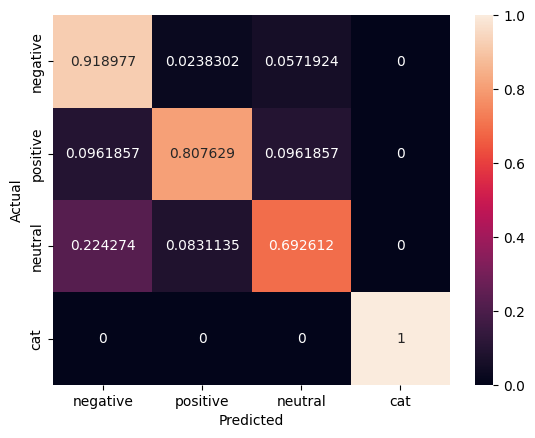

In [159]:
import seaborn as sns
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral','cat']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(test_data['label'],predictions, normalize = 'true')
plot_cm(cm)

### <font size="20px">Conclusion</font>

- Negative Class:
1) 91.90% of negative instances were correctly classified as negative.
2) 2.38% of negative instances were incorrectly classified as positive.
3) 5.72% of negative instances were incorrectly classified as neutral.
4) 0% of negative instances were incorrectly classified as cat.
- Positive Class:
1) 80.76% of positive instances were correctly classified as positive.
2) 9.62% of positive instances were incorrectly classified as negative.
3) 9.62% of positive instances were incorrectly classified as neutral.
4) 0% of positive instances were incorrectly classified as cat.
- Neutral Class:
1) 69.26% of neutral instances were correctly classified as neutral.
2) 22.43% of neutral instances were incorrectly classified as negative.
3) 8.31% of neutral instances were incorrectly classified as positive.
4) 0% of neutral instances were incorrectly classified as cat.
- Cat Class (row 4):
1) 100% of cat instances were correctly classified as cat.


<h4> From the analysis of the confusion matrix, it's evident that the model exhibits high accuracy in predicting the "cat" class, where all instances were correctly classified. However, it's worth noting the noticeable shortcomings in other classes such as "negative", "positive", and "neutral". For instance, the model frequently misclassifies negative instances as neutral, which could impact the accuracy of sentiment analysis. This insight can be valuable for further enhancing the model, perhaps by incorporating additional datasets or refining the training algorithms. </h4>

<hr/>

## 2. Simplify task

### Prepare data

#### Download Dataset


In [ ]:
# !wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

#### Import libraries

In [1]:
import pandas as pd
import numpy as np

#### Load dataset

In [2]:
df = pd.read_csv('AirlineTweets.csv')


#### Taking only required columns

In [3]:
df = df[['airline_sentiment','text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Mapping data to target_map and save as "data_2.csv"

In [4]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data_2.csv', index = False)

#### Load data_2.csv and check how loaded dataset looks like

In [5]:
from datasets import load_dataset

raw_dataset_2 = load_dataset('csv', data_files = 'data_2.csv')

raw_dataset_2

c:\Users\Smeek\miniconda3\envs\Python_3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 14640 examples [00:00, 151310.34 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

### Creating model and training process

Split to train and test

In [6]:
split_2 = raw_dataset_2['train'].train_test_split(test_size=0.25, seed=24)
split_2

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10980
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3660
    })
})

#### Tokenize the data

In [7]:
from transformers import RobertaTokenizer
checkpoint = 'roberta-base' 
tokernizer = RobertaTokenizer.from_pretrained(checkpoint)

# Define tokenizer function
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

tokenized_dataset = split_2.map(tokenize_fn, batched = True)

Map: 100%|██████████| 3660/3660 [00:02<00:00, 1432.82 examples/s]


In [12]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10980
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3660
    })
})

In [13]:
# Import classification model
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

model = RobertaForSequenceClassification.from_pretrained(
    checkpoint, num_labels=3)

c:\Users\Smeek\miniconda3\envs\Python_3_9\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Smeek\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base

Model has more than 124 M parameters and all they are trainable.

In [14]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
RobertaForSequenceClassification                             --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   38,603,520
│    │    └─Embedding: 3-2                                   394,752
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           590,592
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           2,307
To

In [15]:
training_args = TrainingArguments(output_dir='training_dir_2',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [16]:
from sklearn.metrics import f1_score

#Define evaluation metrics, which we will pass during training
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [17]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

c:\Users\Smeek\miniconda3\envs\Python_3_9\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [18]:
trainer.train()

  0%|          | 0/2061 [00:00<?, ?it/s]

 24%|██▍       | 500/2061 [33:27<1:45:57,  4.07s/it]

{'loss': 0.5601, 'grad_norm': 2.947507381439209, 'learning_rate': 3.78699660359049e-05, 'epoch': 0.73}


                                                    
 33%|███▎      | 687/2061 [50:01<1:14:10,  3.24s/it]

{'eval_loss': 0.4861816167831421, 'eval_accuracy': 0.7871584699453552, 'eval_f1_score': 0.7871584699453552, 'eval_runtime': 260.8257, 'eval_samples_per_second': 14.032, 'eval_steps_per_second': 0.222, 'epoch': 1.0}


 49%|████▊     | 1000/2061 [1:11:00<1:12:57,  4.13s/it]

{'loss': 0.4409, 'grad_norm': 16.946956634521484, 'learning_rate': 2.57399320718098e-05, 'epoch': 1.46}


                                                       
 67%|██████▋   | 1374/2061 [1:39:59<38:40,  3.38s/it]

{'eval_loss': 0.4124913215637207, 'eval_accuracy': 0.8437158469945355, 'eval_f1_score': 0.8437158469945355, 'eval_runtime': 264.8093, 'eval_samples_per_second': 13.821, 'eval_steps_per_second': 0.219, 'epoch': 2.0}


 73%|███████▎  | 1500/2061 [1:48:49<36:50,  3.94s/it]   

{'loss': 0.3324, 'grad_norm': 31.889850616455078, 'learning_rate': 1.3609898107714703e-05, 'epoch': 2.18}


 97%|█████████▋| 2000/2061 [2:22:38<03:49,  3.76s/it]

{'loss': 0.2564, 'grad_norm': 0.5826719403266907, 'learning_rate': 1.4798641436196021e-06, 'epoch': 2.91}


                                                     
100%|██████████| 2061/2061 [2:30:54<00:00,  3.39s/it]

{'eval_loss': 0.5067554712295532, 'eval_accuracy': 0.8568306010928962, 'eval_f1_score': 0.8568306010928962, 'eval_runtime': 257.4142, 'eval_samples_per_second': 14.218, 'eval_steps_per_second': 0.225, 'epoch': 3.0}


100%|██████████| 2061/2061 [2:30:56<00:00,  4.39s/it]

{'train_runtime': 9056.9808, 'train_samples_per_second': 3.637, 'train_steps_per_second': 0.228, 'train_loss': 0.39302542324149453, 'epoch': 3.0}


TrainOutput(global_step=2061, training_loss=0.39302542324149453, metrics={'train_runtime': 9056.9808, 'train_samples_per_second': 3.637, 'train_steps_per_second': 0.228, 'train_loss': 0.39302542324149453, 'epoch': 3.0})

### Predict

In [ ]:
!dir training_dir_2

In [21]:
from transformers import pipeline

In [24]:
saved_model_2 = pipeline('text-classification',
                       model='training_dir_2/checkpoint-2061')


In [25]:
split_2['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 3660
})

#### Get prediction

In [26]:
predictions_2 = saved_model_2(split_2['test']['sentence'])

In [27]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions_2 = [get_label(d) for d in predictions_2]

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("acc:",accuracy_score(split_2['test']['label'], predictions_2))

acc: 0.8568306010928962


In [31]:
#Calculate f1 score
print("f1:",f1_score(split_2['test']['label'], predictions_2, average = 'macro'))

f1: 0.8098246796424823


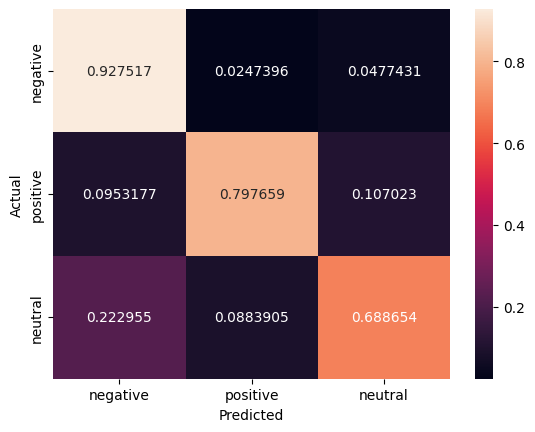

In [33]:
import seaborn as sns
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split_2['test']['label'],predictions_2, normalize = 'true')
plot_cm(cm)

### Comparing models

#### Taking information from Lesson 35 LLM ```fine_tune_bert_for_text_classification.ipynb```


##### Get predictions "bert-base-cased" model

In [ ]:
print("acc:",accuracy_score(split['test']['label'], predictions))

acc: 0.8505464480874317


In [ ]:
#Calculate f1 score
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 0.8024150547625802


##### Plot confusion matrix "bert-base-cased" model

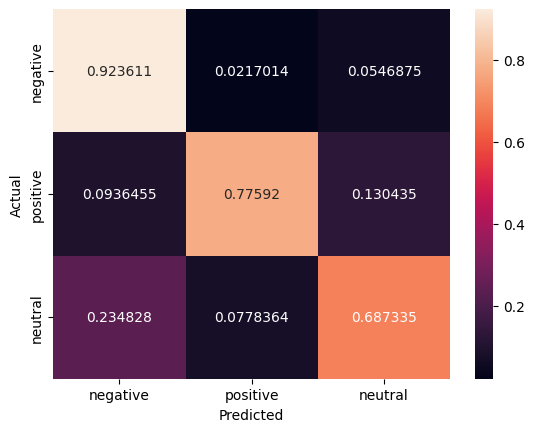

In [ ]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)

#### Now let's compare metrics for 'roberta-base'  model and the bert fine-tuned model (accuracy and f1-score)

<table>
    <tr>
        <td></td>
        <td>"bert-base-cased"</td>
        <td>'roberta-base'</td>
    </tr>
    <tr>
        <td>Accuracy score</td>
        <td>0.85054</td>
        <td>0.85683</td>
    </tr>
    <tr>
        <td>F1 score</td>
        <td>0.80241</td>
        <td>0.85683</td>
    </tr>
</table>

##### <font size="20px">Confusion matrixs:<br/></font>
<font size="20px">"bert-base-cased"<br/></font>


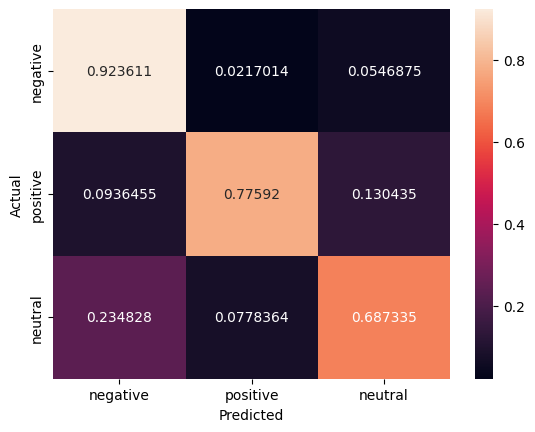<br/>
<font size="20px">'roberta-base'<br/></font>

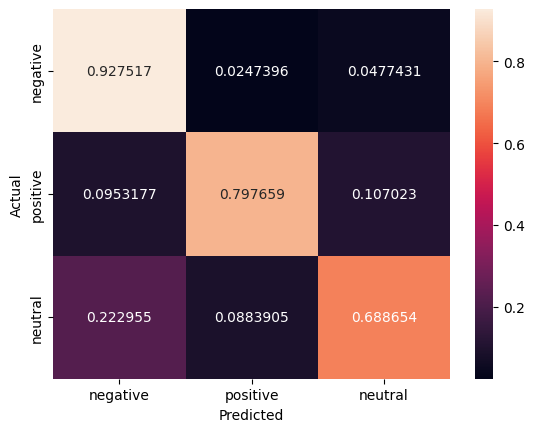<br/>


### <font size="20px">Conclusion</font>


The difference between the two models is not substantial, but `roberta-base` still edges out the `bert-base-cased` model with slightly higher scores in both accuracy and F1 score. This indicates that while the performance improvement is not significant, it is still notable enough to consider `roberta-base` as the slightly superior option for the task at hand.